# **Installing required packages**

In [ ]:
!pip install ecg-plot
!pip install keras
!pip install tensorflow
!pip install ipynb
!pip install scikit-multilearn

# **Importing Necessary Libraries**

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.io import loadmat
import os
import sys
import ecg_plot
import seaborn
from sklearn.preprocessing import MultiLabelBinarizer
import tensorflow as tf
from tensorflow import keras
from keras_preprocessing.sequence import pad_sequences
from keras import backend
backend.set_image_data_format('channels_last')
from sklearn.ensemble import RandomForestClassifier
import pickle
from ipynb.fs.full.supporting_functions import *
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import roc_auc_score
from skmultilearn.model_selection import iterative_train_test_split
import scipy
from scipy.signal import butter,lfilter,freqz

# Data loading, shaping and visualization

## Loading the training, validation and test data.

In [ ]:
data, wave_length, diagnosis , pescription, history, surgery, sex, age= load_data('C:\\Users\\defeo\\Desktop\\Ahmad\\ECG_train')  #Using the load function, load the data

###### Checking the length of the dataset

In [ ]:
print('Number of patients:', len(data))

Number of patients: 43101


## Visualizing the ECG waves

###### Visualizing all the 12 leads data for a specific patient

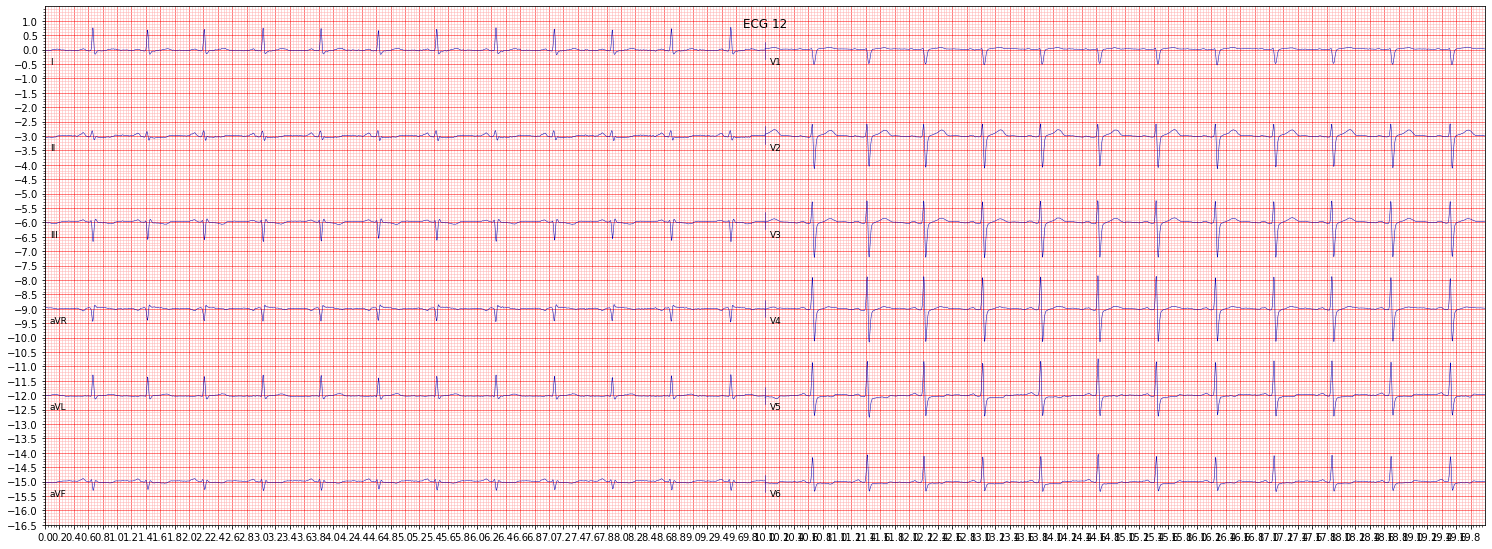

In [ ]:
abc=np.asarray(data[500])
ecg_plot.plot(abc/1000, sample_rate=500) #sample frequency is given in data header file as 500 
ecg_plot.show()                                               #data is divided by 1000 which is the amplitude resolution

###### Visualizing the Lead I data for the same patient

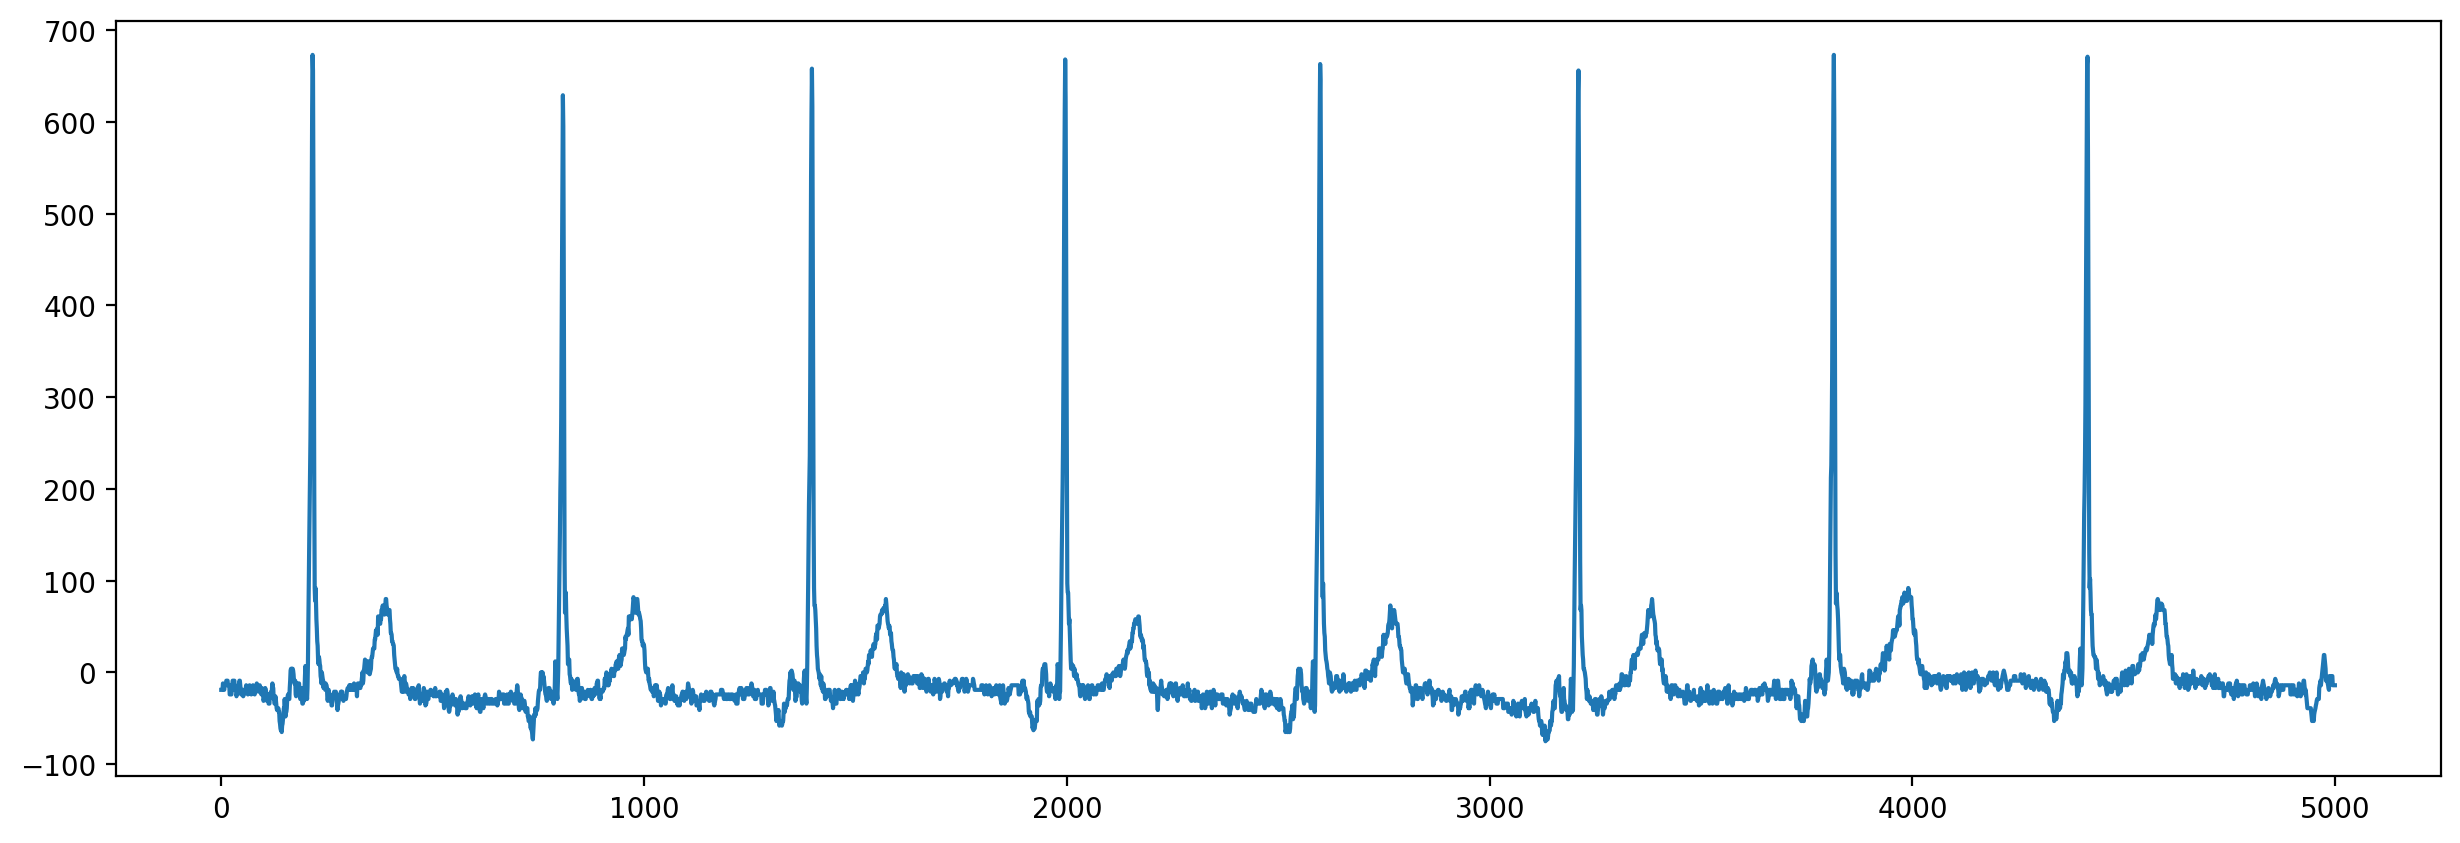

In [ ]:
plt.figure(figsize=(15, 5), dpi=200)
plt.plot(data[16000][4])
plt.show()

###### Removing noise from the data and then visualizing it

In [ ]:
data_noise_removed=butter_lowpass_filter(data[16000][4],30,257,2)  

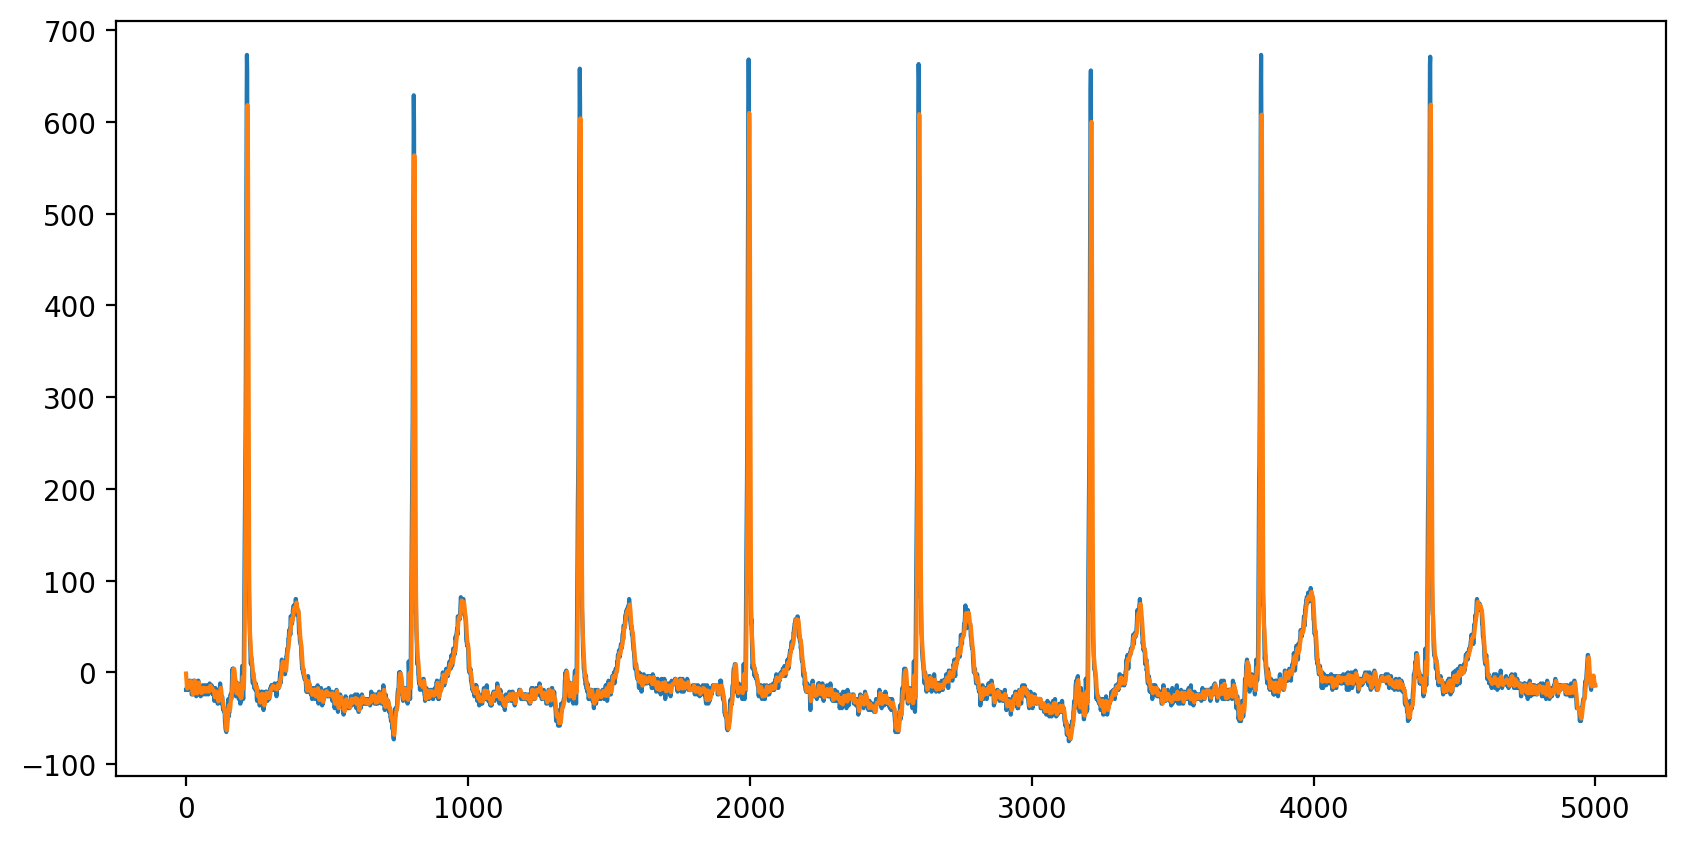

In [ ]:
plt.figure(figsize=(10, 5), dpi=200)
plt.plot(data[16000][4])
plt.plot(data_noise_removed)
plt.show()

## **Encoding the age and and sex demographics**





In [ ]:
sex, age , pescription, history, surgery=demographical_data_encoding(sex,age)

## Combining data vector with demographical features



In [ ]:
# data=data_append_demographics(data,age,sex)
# data_val_combined=data_append_demographics(data_val,age_val,sex_val)
# data_test_combined=data_append_demographics(data_test,age_test,sex_test)

# **Visualizing the distribution of wavelengths across different data samples**

In [ ]:
print('Most frequent occuring wave length:',max(set(wave_length), key = wave_length.count))   

Most frequent occuring wave length: 5000


In [ ]:
wave_length = pd.DataFrame(wave_length)
u=(wave_length[0].unique())
a=pd.DataFrame(u)
print('Number of unique wave data  lengths present:',a[0].count())

Number of unique wave data  lengths present: 1969


Plotting wavelengths along wiith their frequencies

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:title={'center':'Wave Data lengths and their occurance frequencies'}, ylabel='0'>

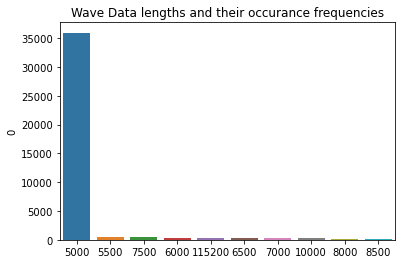

In [ ]:
plt.title('Wave Data lengths and their occurance frequencies')
seaborn.barplot(wave_length[0].value_counts()[:10,].index, wave_length[0].value_counts()[:10,])

# **Encoding the diagnosis(Multi class multi labelled data)**



###### load the unscored labels that we are not classifying

In [ ]:
SNOMED_mappings=pd.read_csv("C:\\Users\\defeo\\Desktop\\Ahmad\\Labels\\SNOMED_mappings_unscored.csv", sep=";")  
SNOMED_mappings
diseases=SNOMED_mappings['SNOMED CT Code'] 

###### converting comma seprated multi labels to type int

In [ ]:
diagnosis_labels=multi_labels_encoding(diagnosis)

###### Unique labels in dataset

In [ ]:
scored_labels=[10370003,111975006,164889003,164890007,164909002,164917005,164934002,164947007,17338001,
 251146004,270492004,284470004,39732003,426177001,426627000,426783006,427084000,427172004,427393009,445118002,47665007,59118001,
 59931005,63593006,698252002,713426002,713427006,0]
print('classes_to_be_classified',scored_labels)

classes_to_be_classified [10370003, 111975006, 164889003, 164890007, 164909002, 164917005, 164934002, 164947007, 17338001, 251146004, 270492004, 284470004, 39732003, 426177001, 426627000, 426783006, 427084000, 427172004, 427393009, 445118002, 47665007, 59118001, 59931005, 63593006, 698252002, 713426002, 713427006, 0]


###### Replacing unscored labels in our data with zeros to get rid of them

In [ ]:
diagnosis_labels=Remove_unscored_labels(diagnosis_labels,diseases)

###### Forming multi class multi labels for each patient

In [ ]:
diagnosis_labels=multi_class_labels(diagnosis_labels,scored_labels)

###### Checking the frequency of the labels

In [ ]:
fr=check_label_freq(diagnosis_labels,scored_labels)
print('Frequency of different diseases:', fr)

Frequency of different diseases: [299, 1513, 3475, 314, 1041, 1013, 4673, 340, 365, 556, 2394, 1729, 6086, 2359, 288, 20846, 2402, 188, 1240, 1806, 427, 2402, 1112, 215, 997, 1611, 683, 21291]


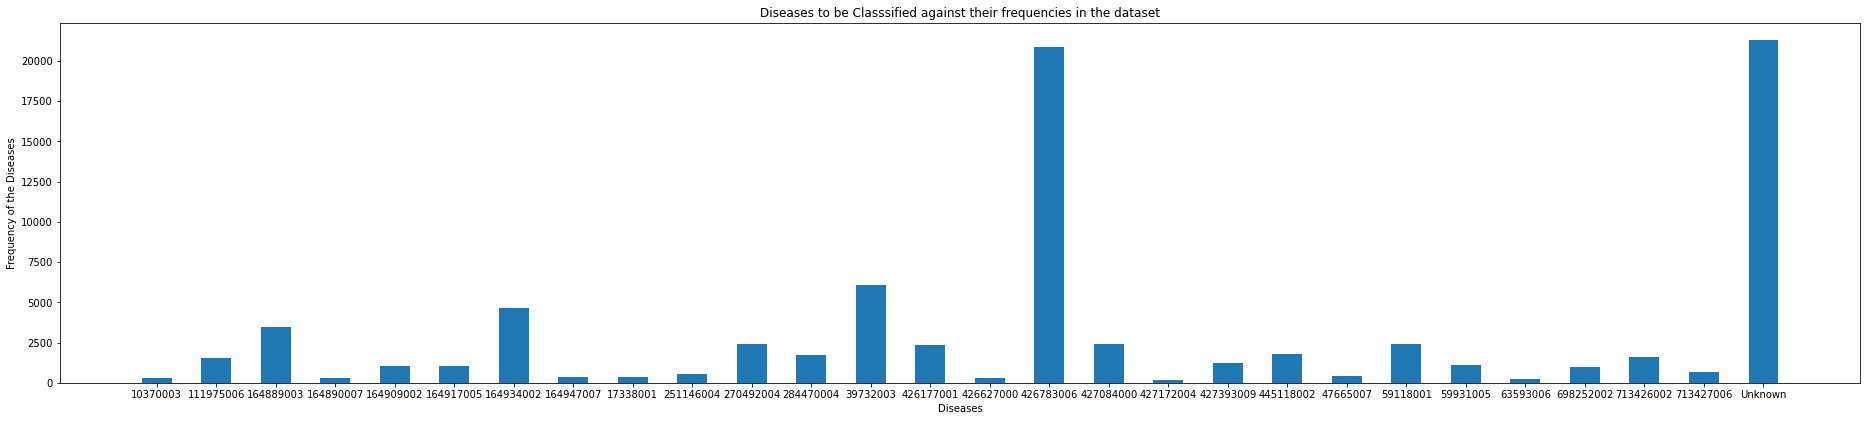

In [ ]:
fig = plt.figure(figsize = (25, 5))
ax = fig.add_axes([0,0,1,1])
diseases=['10370003','111975006','164889003','164890007','164909002','164917005','164934002','164947007','17338001',
 '251146004','270492004','284470004','39732003','426177001','426627000','426783006','427084000','427172004','427393009','445118002','47665007','59118001',
 '59931005','63593006','698252002','713426002','713427006','Unknown']
frequencies =fr
ax.bar(diseases,frequencies,width=0.5)
plt.xlabel("Diseases")
plt.ylabel("Frequency of the Diseases")
plt.title("Diseases to be Classsified against their frequencies in the dataset")
plt.show()

# Splitting the data into train, test and validation maintaining stratification

In [ ]:
data_train, diagnosis_labels_train, data_test, diagnosis_labels_test = iterative_train_test_split(data, diagnosis_labels, test_size = 0.2) #70 percent training and 20 % validation

# Dealing data imbalance by assigning weights to the labels

In [ ]:
new_weights=calculating_class_weights(diagnosis_labels_train)
keys = np.arange(0,28,1)
weight_dictionary = dict(zip(keys, new_weights.T[1]))
weight_dictionary

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass classes=[0.0, 1.0], y=[0 0 0 ... 0 0 0] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass classes=[0.0, 1.0], y=[0 0 1 ... 0 0 0] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass classes=[0.0, 1.0], y=[0 0 0 ... 1 0 1] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\u

{0: 72.61087866108787,
 1: 14.4496253122398,
 2: 6.242446043165468,
 3: 69.13944223107569,
 4: 20.83313325330132,
 5: 22.24871794871795,
 6: 4.763656327202855,
 7: 63.10545454545454,
 8: 59.43150684931507,
 9: 38.997752808988764,
 10: 9.062140992167102,
 11: 12.548083875632683,
 12: 3.5729874408070827,
 13: 9.196608373078961,
 14: 76.1140350877193,
 15: 1.0405948312046531,
 16: 9.05741127348643,
 17: 115.69333333333333,
 18: 17.493951612903224,
 19: 12.264310954063605,
 20: 51.34319526627219,
 21: 9.02913631633715,
 22: 19.498876404494382,
 23: 103.91616766467065,
 24: 22.16347381864623,
 25: 13.838915470494419,
 26: 33.56673114119923,
 27: 1.018845769975929}

# Experimenting our baseline models

###### Removing noise from the data.

In [ ]:
for i in range(len(data_train)):                      #sampling frequency=257, sampling period=10seconds
  for j in range(len(data_train [i])):                            #signal frequency=257/10=25.7, but we keep it 30 a little bit higher than actual
    data_train[i][j]=butter_lowpass_filter(data_train[i][j],30,257,2)       #Order is 2 as ECG is a sin wave 
    
for i in range(len(data_test)):                      #sampling frequency=257, sampling period=10seconds
  for j in range(len(data_test [i])):                            #signal frequency=257/10=25.7, but we keep it 30 a little bit higher than actual
    data_test[i][j]=butter_lowpass_filter(data_test[i][j],30,257,2)       #Order is 2 as ECG is a sin wave 

## Resnet 50 model (Using all 12 leads)

###### **Defining the Model**

In [ ]:
model1=RESNET_50(a = (12,5000))

###### Generating the Model Summary

In [ ]:
model1.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 12, 5000)]   0           []                               
                                                                                                  
 zero_padding1d_3 (ZeroPadding1  (None, 18, 5000)    0           ['input_4[0][0]']                
 D)                                                                                               
                                                                                                  
 conv1d_159 (Conv1D)            (None, 6, 64)        2240064     ['zero_padding1d_3[0][0]']       
                                                                                                  
 batch_normalization_159 (Batch  (None, 6, 64)       256         ['conv1d_159[0][0]']       

###### **Training the  model**

In [ ]:
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', verbose=1, patience=2, mode='auto')  #early stopping criteria
model_check_point=tf.keras.callbacks.ModelCheckpoint(filepath='./',monitor='val_loss',verbose=1,save_best_only=True) #saving the best model
history1=model1.fit(data_train, diagnosis_labels_train, validation_split=0.15, class_weight=weight_dictionary, epochs=50,batch_size=75,callbacks=[early_stop,model_check_point])  #fitting the model on training data

Epoch 1/50
394/394 [==============================] - ETA: 0s - loss: 3.8061 - accuracy: 0.9338 - AUC: 0.7802
Epoch 1: val_loss improved from inf to 2.12407, saving model to .\


INFO:tensorflow:Assets written to: .\assets


INFO:tensorflow:Assets written to: .\assets


394/394 [==============================] - 1000s 3s/step - loss: 3.8061 - accuracy: 0.9338 - AUC: 0.7802 - val_loss: 2.1241 - val_accuracy: 0.9277 - val_AUC: 0.8298
Epoch 2/50
394/394 [==============================] - ETA: 0s - loss: 2.0103 - accuracy: 0.9340 - AUC: 0.8052
Epoch 2: val_loss improved from 2.12407 to 0.36818, saving model to .\


INFO:tensorflow:Assets written to: .\assets


INFO:tensorflow:Assets written to: .\assets


394/394 [==============================] - 1448s 4s/step - loss: 2.0103 - accuracy: 0.9340 - AUC: 0.8052 - val_loss: 0.3682 - val_accuracy: 0.9273 - val_AUC: 0.8553
Epoch 3/50
394/394 [==============================] - ETA: 0s - loss: 1.9561 - accuracy: 0.9341 - AUC: 0.8114
Epoch 3: val_loss did not improve from 0.36818
394/394 [==============================] - 1682s 4s/step - loss: 1.9561 - accuracy: 0.9341 - AUC: 0.8114 - val_loss: 0.7328 - val_accuracy: 0.9276 - val_AUC: 0.8384
Epoch 4/50
394/394 [==============================] - ETA: 0s - loss: 1.9606 - accuracy: 0.9341 - AUC: 0.8125
Epoch 4: val_loss improved from 0.36818 to 0.32460, saving model to .\


INFO:tensorflow:Assets written to: .\assets


INFO:tensorflow:Assets written to: .\assets


394/394 [==============================] - 1691s 4s/step - loss: 1.9606 - accuracy: 0.9341 - AUC: 0.8125 - val_loss: 0.3246 - val_accuracy: 0.9264 - val_AUC: 0.8455
Epoch 5/50
394/394 [==============================] - ETA: 0s - loss: 2.0193 - accuracy: 0.9341 - AUC: 0.8052
Epoch 5: val_loss improved from 0.32460 to 0.20782, saving model to .\


INFO:tensorflow:Assets written to: .\assets


INFO:tensorflow:Assets written to: .\assets


394/394 [==============================] - 1641s 4s/step - loss: 2.0193 - accuracy: 0.9341 - AUC: 0.8052 - val_loss: 0.2078 - val_accuracy: 0.9270 - val_AUC: 0.8438
Epoch 6/50
394/394 [==============================] - ETA: 0s - loss: 1.9595 - accuracy: 0.9342 - AUC: 0.8098
Epoch 6: val_loss did not improve from 0.20782
394/394 [==============================] - 1636s 4s/step - loss: 1.9595 - accuracy: 0.9342 - AUC: 0.8098 - val_loss: 0.2276 - val_accuracy: 0.9270 - val_AUC: 0.7849
Epoch 7/50
394/394 [==============================] - ETA: 0s - loss: 1.9433 - accuracy: 0.9342 - AUC: 0.8145
Epoch 7: val_loss did not improve from 0.20782
394/394 [==============================] - 1625s 4s/step - loss: 1.9433 - accuracy: 0.9342 - AUC: 0.8145 - val_loss: 0.2530 - val_accuracy: 0.9276 - val_AUC: 0.8182
Epoch 7: early stopping


###### Plotting Validation Loss Against Training Loss

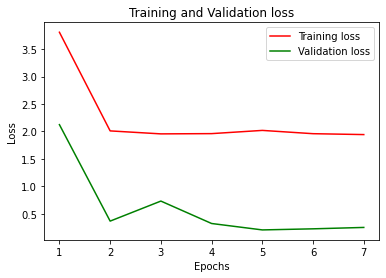

In [ ]:
train_loss = history1.history['loss']
val_loss = history1.history['val_loss']
epochs = range(1,8)
plt.plot(epochs, train_loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'g', label='Validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

###### Plotting Validation Accuracy Against Training Accuracy

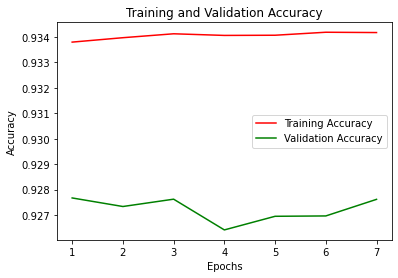

In [ ]:
train_accuracy = history1.history['accuracy']
val_accuracy = history1.history['val_accuracy']
epochs = range(1,8)
plt.plot(epochs, train_accuracy, 'r', label='Training Accuracy')
plt.plot(epochs, val_accuracy, 'g', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

###### Plotting Validation AUCROC against training AUCROC

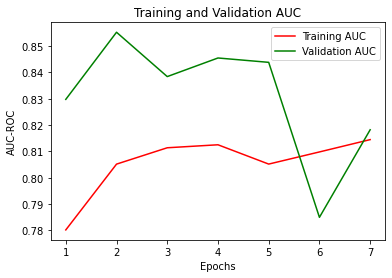

In [ ]:
train_AUC = history1.history['AUC']
val_AUC= history1.history['val_AUC']
epochs = range(1,8)
plt.plot(epochs, train_AUC, 'r', label='Training AUC')
plt.plot(epochs, val_AUC, 'g', label='Validation AUC')
plt.title('Training and Validation AUC')
plt.xlabel('Epochs')
plt.ylabel('AUC-ROC')
plt.legend()
plt.show()

###### Saving the trained model

In [ ]:
model1.save('./model1.h5')

###### Loading the trained Model

In [ ]:
model1= tf.keras.models.load_model('./model1.h5' )

###### **Predicting values of test dataset on trained model**

In [ ]:
resnet50v0_predictions=model1.predict(data_test)   #predicting values for the test data

263/263 [==============================] - 14s 52ms/step


###### **Accuracy on the test data**

In [ ]:
print(np.equal(diagnosis_labels_test, np.round(resnet50v0_predictions)).mean())  #Accuracy on the test data

0.9294311932853228


## Resnet 50 model  (using only limb leads)

###### Creating a dataset with only chest leads

In [ ]:
leadlimb_data_train=[]
leadlimb_data_test=[]
for i in range(len(data_train)):
    d1=[]
    for j in range(len(data_train[i])):
        if(j>=6):
            d1.append(data_train[i][j])
    d1=np.asarray(d1)
    leadlimb_data_train.append(d1)
leadlimb_data_train=np.asarray(leadlimb_data_train)

for i in range(len(data_test)):
    d1=[]
    for j in range(len(data_test[i])):
        if(j>=6):
            d1.append(data_test[i][j])
    d1=np.asarray(d1)
    leadlimb_data_test.append(d1)
leadlimb_data_test=np.asarray(leadlimb_data_test)

###### Defining the model

In [ ]:
model2=RESNET_50(a = (6,5000))

###### Generating the Model Summary

In [ ]:
model2.summary()

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 6, 5000)]    0           []                               
                                                                                                  
 zero_padding1d_4 (ZeroPadding1  (None, 12, 5000)    0           ['input_5[0][0]']                
 D)                                                                                               
                                                                                                  
 conv1d_212 (Conv1D)            (None, 3, 64)        2240064     ['zero_padding1d_4[0][0]']       
                                                                                                  
 batch_normalization_212 (Batch  (None, 3, 64)       256         ['conv1d_212[0][0]']       

###### Training the model

In [ ]:
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', verbose=1, patience=2, mode='auto')  #early stopping criteria
model_check_point=tf.keras.callbacks.ModelCheckpoint(filepath='./',monitor='val_loss',verbose=1,save_best_only=True) #saving the best model
history2=model2.fit(leadlimb_data_train, diagnosis_labels_train, validation_split=0.15, class_weight=weight_dictionary, epochs=50,batch_size=75,callbacks=[early_stop,model_check_point])  #fitting the model on training data

Epoch 1/50
394/394 [==============================] - ETA: 0s - loss: 3.0381 - accuracy: 0.9338 - AUC: 0.7931
Epoch 1: val_loss improved from inf to 0.27486, saving model to .\


INFO:tensorflow:Assets written to: .\assets


INFO:tensorflow:Assets written to: .\assets


394/394 [==============================] - 913s 2s/step - loss: 3.0381 - accuracy: 0.9338 - AUC: 0.7931 - val_loss: 0.2749 - val_accuracy: 0.9271 - val_AUC: 0.8516
Epoch 2/50
394/394 [==============================] - ETA: 0s - loss: 1.9801 - accuracy: 0.9342 - AUC: 0.8081
Epoch 2: val_loss improved from 0.27486 to 0.23684, saving model to .\


INFO:tensorflow:Assets written to: .\assets


INFO:tensorflow:Assets written to: .\assets


394/394 [==============================] - 1662s 4s/step - loss: 1.9801 - accuracy: 0.9342 - AUC: 0.8081 - val_loss: 0.2368 - val_accuracy: 0.9271 - val_AUC: 0.8348
Epoch 3/50
394/394 [==============================] - ETA: 0s - loss: 1.9561 - accuracy: 0.9342 - AUC: 0.8131
Epoch 3: val_loss did not improve from 0.23684
394/394 [==============================] - 1649s 4s/step - loss: 1.9561 - accuracy: 0.9342 - AUC: 0.8131 - val_loss: 0.2524 - val_accuracy: 0.9265 - val_AUC: 0.8418
Epoch 4/50
394/394 [==============================] - ETA: 0s - loss: 1.9382 - accuracy: 0.9341 - AUC: 0.8159
Epoch 4: val_loss improved from 0.23684 to 0.19818, saving model to .\


INFO:tensorflow:Assets written to: .\assets


INFO:tensorflow:Assets written to: .\assets


394/394 [==============================] - 1664s 4s/step - loss: 1.9382 - accuracy: 0.9341 - AUC: 0.8159 - val_loss: 0.1982 - val_accuracy: 0.9267 - val_AUC: 0.8608
Epoch 5/50
394/394 [==============================] - ETA: 0s - loss: 1.9358 - accuracy: 0.9342 - AUC: 0.8171
Epoch 5: val_loss did not improve from 0.19818
394/394 [==============================] - 1905s 5s/step - loss: 1.9358 - accuracy: 0.9342 - AUC: 0.8171 - val_loss: 0.4698 - val_accuracy: 0.9268 - val_AUC: 0.8329
Epoch 6/50
394/394 [==============================] - ETA: 0s - loss: 1.9334 - accuracy: 0.9341 - AUC: 0.8171
Epoch 6: val_loss did not improve from 0.19818
394/394 [==============================] - 1899s 5s/step - loss: 1.9334 - accuracy: 0.9341 - AUC: 0.8171 - val_loss: 0.2869 - val_accuracy: 0.9268 - val_AUC: 0.8335
Epoch 6: early stopping


###### Plotting Validation Loss Against Training Loss

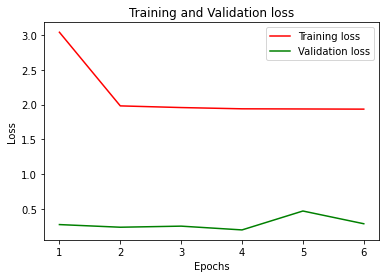

In [ ]:
train_loss = history2.history['loss']
val_loss = history2.history['val_loss']
epochs = range(1,7)
plt.plot(epochs, train_loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'g', label='Validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

###### Plotting Validation accuracy Against Training accuracy

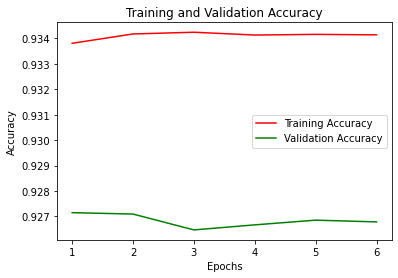

In [ ]:
train_accuracy = history2.history['accuracy']
val_accuracy = history2.history['val_accuracy']
epochs = range(1,7)
plt.plot(epochs, train_accuracy, 'r', label='Training Accuracy')
plt.plot(epochs, val_accuracy, 'g', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

###### Plotting Validation AUC Against Training AUC

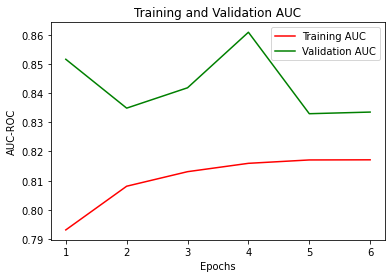

In [ ]:
train_AUC = history2.history['AUC']
val_AUC= history2.history['val_AUC']
epochs = range(1,7)
plt.plot(epochs, train_AUC, 'r', label='Training AUC')
plt.plot(epochs, val_AUC, 'g', label='Validation AUC')
plt.title('Training and Validation AUC')
plt.xlabel('Epochs')
plt.ylabel('AUC-ROC')
plt.legend()
plt.show()

###### Saving the Model

In [ ]:
model2.save('./model2.h5')

###### Loading the trained model

In [ ]:
model2= tf.keras.models.load_model('./model2.h5' )

###### **Predicting values of test dataset on trained model**

In [ ]:
resnet50v1_predictions=model2.predict(leadlimb_data_test)   #predicting values for the test data

263/263 [==============================] - 12s 45ms/step


###### **Accuracy on the test data**

In [ ]:
print(np.equal(diagnosis_labels_test, np.round(resnet50v1_predictions)).mean())  #Accuracy on the test data

0.929320530500366


# Resnet 50 model  (using only chest leads)

###### Creating a dataset with only limb leads

In [ ]:
leadchest_data_train=[]
leadchest_data_test=[]

for i in range(len(data_train)):
    d1=[]
    for j in range(len(data_train[i])):
        if(j<6):
            d1.append(data_train[i][j])
    d1=np.asarray(d1)
    leadchest_data_train.append(d1)
leadchest_data_train=np.asarray(leadchest_data_train)

for i in range(len(data_test)):
    d1=[]
    for j in range(len(data_test[i])):
        if(j<6):
            d1.append(data_test[i][j])
    d1=np.asarray(d1)
    leadchest_data_test.append(d1)
leadchest_data_test=np.asarray(leadchest_data_test)

###### Defining the model

In [ ]:
model3=RESNET_50(a = (6,5000))

###### Generating the Model Summary

In [ ]:
model3.summary()

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_6 (InputLayer)           [(None, 6, 5000)]    0           []                               
                                                                                                  
 zero_padding1d_5 (ZeroPadding1  (None, 12, 5000)    0           ['input_6[0][0]']                
 D)                                                                                               
                                                                                                  
 conv1d_265 (Conv1D)            (None, 3, 64)        2240064     ['zero_padding1d_5[0][0]']       
                                                                                                  
 batch_normalization_265 (Batch  (None, 3, 64)       256         ['conv1d_265[0][0]']       

###### Training the Model

In [ ]:
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', verbose=1, patience=2, mode='auto')  #early stopping criteria
model_check_point=tf.keras.callbacks.ModelCheckpoint(filepath='./',monitor='val_loss',verbose=1,save_best_only=True) #saving the best model
history3=model3.fit(leadchest_data_train, diagnosis_labels_train, validation_split=0.15, class_weight=weight_dictionary, epochs=50,batch_size=75,callbacks=[early_stop,model_check_point])  #fitting the model on training data

Epoch 1/50
394/394 [==============================] - ETA: 0s - loss: 2.2884 - accuracy: 0.9337 - AUC: 0.7903
Epoch 1: val_loss improved from inf to 0.29189, saving model to .\


INFO:tensorflow:Assets written to: .\assets


INFO:tensorflow:Assets written to: .\assets


394/394 [==============================] - 1524s 4s/step - loss: 2.2884 - accuracy: 0.9337 - AUC: 0.7903 - val_loss: 0.2919 - val_accuracy: 0.9271 - val_AUC: 0.8504
Epoch 2/50
394/394 [==============================] - ETA: 0s - loss: 1.9736 - accuracy: 0.9341 - AUC: 0.8081
Epoch 2: val_loss improved from 0.29189 to 0.20123, saving model to .\


INFO:tensorflow:Assets written to: .\assets


INFO:tensorflow:Assets written to: .\assets


394/394 [==============================] - 1915s 5s/step - loss: 1.9736 - accuracy: 0.9341 - AUC: 0.8081 - val_loss: 0.2012 - val_accuracy: 0.9269 - val_AUC: 0.8591
Epoch 3/50
394/394 [==============================] - ETA: 0s - loss: 1.9564 - accuracy: 0.9342 - AUC: 0.8119
Epoch 3: val_loss did not improve from 0.20123
394/394 [==============================] - 1842s 5s/step - loss: 1.9564 - accuracy: 0.9342 - AUC: 0.8119 - val_loss: 0.2776 - val_accuracy: 0.9277 - val_AUC: 0.8258
Epoch 4/50
394/394 [==============================] - ETA: 0s - loss: 1.9470 - accuracy: 0.9341 - AUC: 0.8146
Epoch 4: val_loss did not improve from 0.20123
394/394 [==============================] - 1832s 5s/step - loss: 1.9470 - accuracy: 0.9341 - AUC: 0.8146 - val_loss: 0.2296 - val_accuracy: 0.9247 - val_AUC: 0.8272
Epoch 4: early stopping


###### Plotting Validation Loss Against the Training Loss

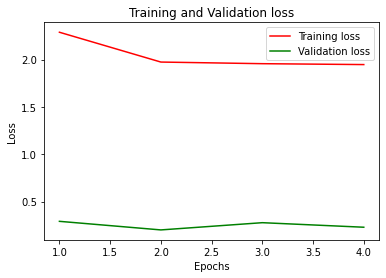

In [ ]:
train_loss = history3.history['loss']
val_loss = history3.history['val_loss']
epochs = range(1,5)
plt.plot(epochs, train_loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'g', label='Validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

###### Plotting Validation Accuracy Against the Training Accuracy

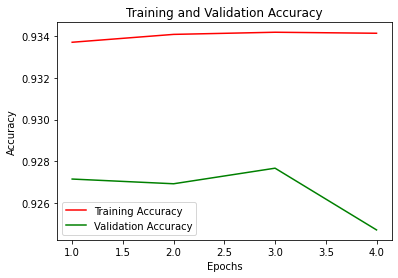

In [ ]:
train_accuracy = history3.history['accuracy']
val_accuracy = history3.history['val_accuracy']
epochs = range(1,5)
plt.plot(epochs, train_accuracy, 'r', label='Training Accuracy')
plt.plot(epochs, val_accuracy, 'g', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

###### Plotting Validation AUC Against the Training AUC

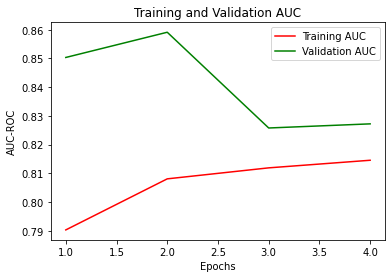

In [ ]:
train_AUC = history3.history['AUC']
val_AUC= history3.history['val_AUC']
epochs = range(1,5)
plt.plot(epochs, train_AUC, 'r', label='Training AUC')
plt.plot(epochs, val_AUC, 'g', label='Validation AUC')
plt.title('Training and Validation AUC')
plt.xlabel('Epochs')
plt.ylabel('AUC-ROC')
plt.legend()
plt.show()

###### Saving the Model

In [ ]:
model3.save('./model3.h5')

###### Loading the trained Model

In [ ]:
model3= tf.keras.models.load_model('./model3.h5' )

###### Predicting values of test dataset on trained model

In [ ]:
resnet50v2_predictions=model3.predict(leadchest_data_test)   #predicting values for the test data

263/263 [==============================] - 12s 44ms/step


###### Accuracy on the test data

In [ ]:
print(np.equal(diagnosis_labels_test, np.round(resnet50v2_predictions)).mean())  #Accuracy on the test data

0.9290267399703834


# Ensembling all the Models to calculate the Accuracy

In [ ]:
final_predictions=resnet50v2_predictions
maximum=0.0
final_w1=0.0
final_w2=0.0
final_w3=0.0
for w1 in range(0,10):
    for w2 in range(0,10):
        for w3 in range(0,10):
            w1=w1/10
            w2=w2/10
            w3=w3/10
            for i in range(len(resnet50v2_predictions)):
                for j in range(len(resnet50v2_predictions[i])):
                    a=(resnet50v0_predictions[i][j])*w1
                    b=(resnet50v1_predictions[i][j])*w2
                    c=(resnet50v2_predictions[i][j])*w3
                    final_predictions[i][j]=max(a,b,c)
            temp=np.equal(diagnosis_labels_test, np.round(final_predictions)).mean()
            if temp>maximum:
                maximum=temp
                final_w1=w1
                final_w2=w2
                final_w3=w3
print('Maximum Accuracy Achieved:',maximum)

In [ ]:
print('Maximum Accuracy Achieved:',maximum)

Maximum Accuracy Achieved: 0.94567356740345
